# PFAS Cost-Risk Analysis

## Overview
This notebook analyzes the cost-effectiveness of different PFAS treatment scenarios using UCMR5 data.

## Starting Dataset
- Source: `system_max_with_population` from `Pfas_ucmr5_analysis.ipynb`
- Systems: 9,771 water systems with population data
- Key columns: PWSID, PFOA, PFOS, POPULATION_SERVED_COUNT, population_bin

## Objectives
1. Estimate treatment costs for varying regulatory thresholds (4, 8, 12, 20, 40 ng/L)
2. Calculate risk reduction (ng×person/day) for each scenario
3. Determine the cost-effectiveness of different treatment targets
4. Visualize trade-offs between costs and public health benefits

In [ ]:
# Load necessary Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read the data from system_max_with_population file
df = pd.read_csv('system_max_with_population_clean.csv')

In [3]:
df.head()

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
0,AK2110342,0.0,0.0,False,38526.0,"10,001 - 50,000"
1,AK2110601,0.0,0.0,False,10947.0,"10,001 - 50,000"
2,AK2120232,0.0,0.0,False,8937.0,"3,301 - 10,000"
3,AK2130075,0.0,0.0,False,9448.0,"3,301 - 10,000"
4,AK2210605,0.0,0.0,False,794.0,"501 - 1,000"


In [4]:
df.tail()

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
9766,WY5601569,0.0,0.0,False,580.0,"501 - 1,000"
9767,WY5680074,0.0,0.0,False,4300.0,"3,301 - 10,000"
9768,WY5680085,0.0,0.0,False,7675.0,"3,301 - 10,000"
9769,WY5680095,0.0,0.0,False,4514.0,"3,301 - 10,000"
9770,WY5680122,0.0,0.0,False,5500.0,"3,301 - 10,000"


In [5]:
df.sample(10)

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
2083,GA1230000,0.0000,0.0,False,13010.0,"10,001 - 50,000"
7631,TN0000247,0.0000,0.0,False,38032.0,"10,001 - 50,000"
2478,IL0195300,0.0000,0.0,False,150000.0,"100,001 - 1,000,000"
7139,PA6270008,0.0000,0.0,False,4320.0,"3,301 - 10,000"
131,AL0000578,0.0000,0.0,False,6465.0,"3,301 - 10,000"
1706,FL3350858,0.0055,0.0,True,39204.0,"10,001 - 50,000"
8953,UTAH18028,0.0000,0.0,False,99750.0,"50,001 - 100,000"
214,AL0001015,0.0000,0.0,False,29253.0,"10,001 - 50,000"
7597,TN0000144,0.0000,0.0,False,14334.0,"10,001 - 50,000"
2767,IL1130750,0.0000,0.0,False,3498.0,"3,301 - 10,000"


In [6]:
df.query('`exceeds_threshold(0.004*0.8)` == True') 

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
5,AK2210906,0.0091,0.0000,True,221351.0,"100,001 - 1,000,000"
21,AK2310730,0.0054,0.0000,True,78324.0,"50,001 - 100,000"
22,AK2310900,0.0064,0.0000,True,27000.0,"10,001 - 50,000"
24,AK2320078,0.0000,0.0463,True,4900.0,"3,301 - 10,000"
29,AL0000013,0.0161,0.0202,True,8670.0,"3,301 - 10,000"
...,...,...,...,...,...,...
9734,WV3305405,0.0132,0.0000,True,5674.0,"3,301 - 10,000"
9735,WV3305407,0.0465,0.0000,True,34251.0,"10,001 - 50,000"
9736,WV3305410,0.0058,0.0000,True,7252.0,"3,301 - 10,000"
9738,WV3305412,0.0320,0.0000,True,3469.0,"3,301 - 10,000"


In [7]:
total_systems = len(df)
exceeding_systems = len(df.query('`exceeds_threshold(0.004*0.8)` == True'))
non_exceeding_systems = total_systems - exceeding_systems
percent_exceed = (exceeding_systems / total_systems) * 100

print("=== Exceedance Summary (0.0032 µg/L threshold) ===")
print(f"Total number of systems: {total_systems:,}")
print(f"Systems exceeding threshold: {exceeding_systems:,}")
print(f"Systems NOT exceeding threshold: {non_exceeding_systems:,}")
print(f"Percentage exceeding: {percent_exceed:.2f}%")


=== Exceedance Summary (0.0032 µg/L threshold) ===
Total number of systems: 9,771
Systems exceeding threshold: 1,611
Systems NOT exceeding threshold: 8,160
Percentage exceeding: 16.49%


### PFAS Threshold Exceedance (4–40 ng/L)

Our dataset reports PFOA and PFOS in µg/L, we convert thresholds from ng/L → µg/L:

- 4 ng/L → 0.004 µg/L  
- 8 ng/L → 0.008 µg/L  
- 12 ng/L → 0.012 µg/L  
- 20 ng/L → 0.020 µg/L  
- 40 ng/L → 0.040 µg/L  

We then compute:

`total_pfas = PFOA + PFOS`

For each threshold, we create a column (`exceeds_4`, `exceeds_8`, …) that is True if `total_pfas` exceeds the converted value.

These columns define which systems would require treatment under different regulatory scenarios.


In [8]:
# create a new column in the df total_pfas adding both the pfas.
df['total_pfas'] = df['PFOA'] + df['PFOS']

In [9]:
thresholds_ng = [4, 8, 12, 20, 40]

for t in thresholds_ng:
    col_name = f"exceeds_{t}"
    threshold_ug = t / 1000   # convert ng/L → µg/L
    df[col_name] = df['total_pfas'] > threshold_ug

In [10]:
df[['total_pfas', 'exceeds_4', 'exceeds_8', 'exceeds_12', 'exceeds_20', 'exceeds_40']].sample(10)

,total_pfas,exceeds_4,exceeds_8,exceeds_12,exceeds_20,exceeds_40
7047,0.0000,False,False,False,False,False
1387,0.0042,True,False,False,False,False
8232,0.0000,False,False,False,False,False
4842,0.0000,False,False,False,False,False
8244,0.0000,False,False,False,False,False
6866,0.0112,True,True,False,False,False
4682,0.0000,False,False,False,False,False
4450,0.0000,False,False,False,False,False
2549,0.0000,False,False,False,False,False
6111,0.0000,False,False,False,False,False


In [11]:
print("=== Number of Systems Exceeding Each Threshold ===")
for t in thresholds_ng:
    col = f"exceeds_{t}"
    count = df[col].sum()
    percent = (count / len(df)) * 100
    print(f"{t} ng/L: {count:,} systems ({percent:.2f}%)")

=== Number of Systems Exceeding Each Threshold ===
4 ng/L: 1,584 systems (16.21%)
8 ng/L: 1,037 systems (10.61%)
12 ng/L: 737 systems (7.54%)
20 ng/L: 356 systems (3.64%)
40 ng/L: 88 systems (0.90%)


### Estimated Flow (MGD)

The flow for each water system is estimated using:

Flow (MGD) = (Population × 109) / 1,000,000

where 109 represents average gallons of water used per person per day, and dividing by 1,000,000 converts gallons/day into million gallons per day (MGD).


In [12]:
df['flow_MGD'] = ((df['POPULATION_SERVED_COUNT']*109)/ 1_000_000)
df[['POPULATION_SERVED_COUNT', 'flow_MGD']].head()

,POPULATION_SERVED_COUNT,flow_MGD
0,38526.0,4.199334
1,10947.0,1.193223
2,8937.0,0.974133
3,9448.0,1.029832
4,794.0,0.086546


### Risk Reduction (ng·person/day)

Risk reduction is calculated as:

$$\text{risk\_reduction} = (\text{PFOA} + \text{PFOS}) \times \text{flow\_MGD} \times \text{population} \times 3780$$

where 3780 is the unit conversion factor that converts the result into ng·person/day.

Risk reduction estimates how much PFAS exposure is prevented if a system installs treatment.


In [13]:
df['risk_reduction'] = (
    df['total_pfas'] *
    df['flow_MGD'] *
    df['POPULATION_SERVED_COUNT'] *
    3780
)
df[['total_pfas', 'flow_MGD', 'POPULATION_SERVED_COUNT', 'risk_reduction']].sample(10)

,total_pfas,flow_MGD,POPULATION_SERVED_COUNT,risk_reduction
3116,0.0000,0.730300,6700.0,0.000000e+00
5590,0.0000,5.157335,47315.0,0.000000e+00
585,0.0000,4.612444,42316.0,0.000000e+00
8241,0.0042,1.896273,17397.0,5.237407e+05
9616,0.0000,1.090000,10000.0,0.000000e+00
2822,0.0065,14.995675,137575.0,5.068865e+07
6509,0.0000,3.862633,35437.0,0.000000e+00
9477,0.0000,0.074338,682.0,0.000000e+00
6837,0.0045,3.131243,28727.0,1.530070e+06
6893,0.0000,0.545000,5000.0,0.000000e+00


In [14]:
# mapping population bin with facility annualized cost column of Table 4 in the Corona memo

popbin_cost_map = {
    '25 - 100': 0.07,
    '101 - 500': 0.12,
    '501 - 1,000': 0.17,
    '1,001 - 3,300': 0.25,
    '3,301 - 10,000': 0.40,
    '10,001 - 50,000': 0.76,
    '50,001 - 100,000': 1.29,
    '100,001 - 1,000,000': 2.33,
    '> 1,000,000': 4.76
}

df['annualized_cost_M'] = df['population_bin'].map(popbin_cost_map)
df[['population_bin', 'annualized_cost_M']].sample(10)

,population_bin,annualized_cost_M
1989,101 - 500,0.12
6149,"10,001 - 50,000",0.76
1593,"10,001 - 50,000",0.76
4052,"501 - 1,000",0.17
390,"10,001 - 50,000",0.76
5954,"1,001 - 3,300",0.25
3626,"3,301 - 10,000",0.40
5202,"3,301 - 10,000",0.40
3300,"10,001 - 50,000",0.76
509,"10,001 - 50,000",0.76


In [16]:
# sum up  total national treatment costs for each of 4, 8, 12, 20, 40 scenarios
national_treatment_costs = {}

for t in thresholds_ng:
    col = f"exceeds_{t}"
    total_cost_M = (df['annualized_cost_M'] * df[col]).sum()
    national_treatment_costs[t] = round(float(total_cost_M), 2)

national_treatment_costs

{4: 1335.05, 8: 887.73, 12: 647.3, 20: 333.77, 40: 84.49}

### National Annualized Cost Results

Using the population-bin specific annualized cost values from the Corona (Black & Veatch)
technical memo, the total national annualized cost for each PFAS regulatory scenario is:

| Threshold (ng/L) | National Cost ($M) |
|------------------|--------------------|
| 4 ng/L           | 1335.05            |
| 8 ng/L           | 887.73             |
| 12 ng/L          | 647.30             |
| 20 ng/L          | 333.77             |
| 40 ng/L          | 84.49              |


### Total National Risk Reduction (ng·person/day)

For each PFAS threshold (4, 8, 12, 20, 40 ng/L), total national risk reduction is
computed as:

$$\text{Total Risk Reduction}_T = \sum (\text{risk\_reduction} \times \text{exceeds}_T)$$

This represents the nationwide reduction in PFAS exposure for all systems that would
require treatment under threshold **T**.


In [17]:
national_risk = {}

for t in thresholds_ng:
    col = f"exceeds_{t}"
    total_risk = (df['risk_reduction'] * df[col]).sum()
    national_risk[t] = round(float(total_risk), 2)

national_risk


{4: 260231543726.6,
 8: 241450366117.12,
 12: 223828781252.1,
 20: 175397803443.78,
 40: 127076229288.2}

### Cost-Effectiveness

Cost-effectiveness for each PFAS threshold is calculated as:

$$\text{Cost-Effectiveness}_T = \frac{ \text{Total Annualized Cost}_T \times 365 }{ \text{Total Risk Reduction}_T }$$

This represents the dollars spent per unit reduction in population PFAS exposure
(ng·person/day).


In [18]:
cost_effectiveness = {}

for t in thresholds_ng:
    total_cost_M = national_treatment_costs[t]          # millions of dollars
    total_risk = national_risk[t]             # ng·person/day

    # convert cost from $M to $, multiply by 365 for annual basis
    ce = (total_cost_M * 1_000_000 * 365) / total_risk

    cost_effectiveness[t] = ce

cost_effectiveness


{4: 1.8725372144429642,
 8: 1.341979534803552,
 12: 1.055559069206089,
 20: 0.6945699866706069,
 40: 0.24267992662939067}

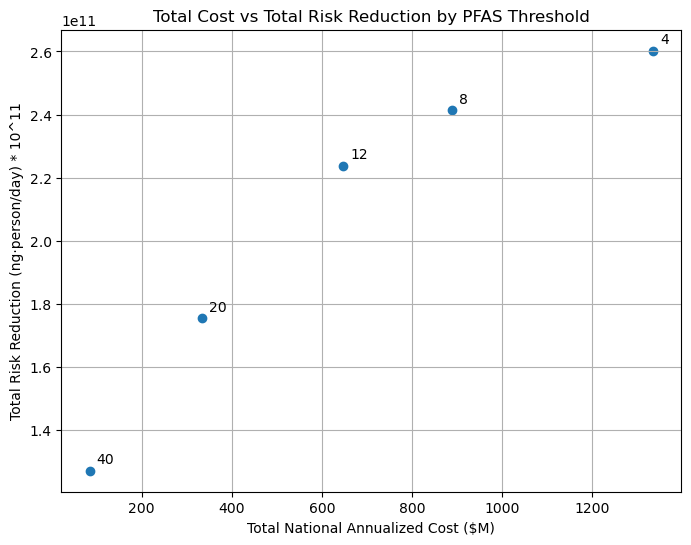

In [19]:
# Extract values in the correct order
costs = [national_treatment_costs[t] for t in thresholds_ng]     # $M
risks = [national_risk[t] for t in thresholds_ng]       # ng*person/day

plt.figure(figsize=(8,6))
plt.scatter(costs, risks)

# Label each point with its threshold (4, 8, 12, 20, 40)
for t, x, y in zip(thresholds_ng, costs, risks):
    plt.annotate(str(t),
                 (x, y),
                 textcoords="offset points",
                 xytext=(5,5))

plt.xlabel("Total National Annualized Cost ($M)")
plt.ylabel("Total Risk Reduction (ng·person/day) * 10^11")
plt.title("Total Cost vs Total Risk Reduction by PFAS Threshold")
plt.grid(True)
plt.show()

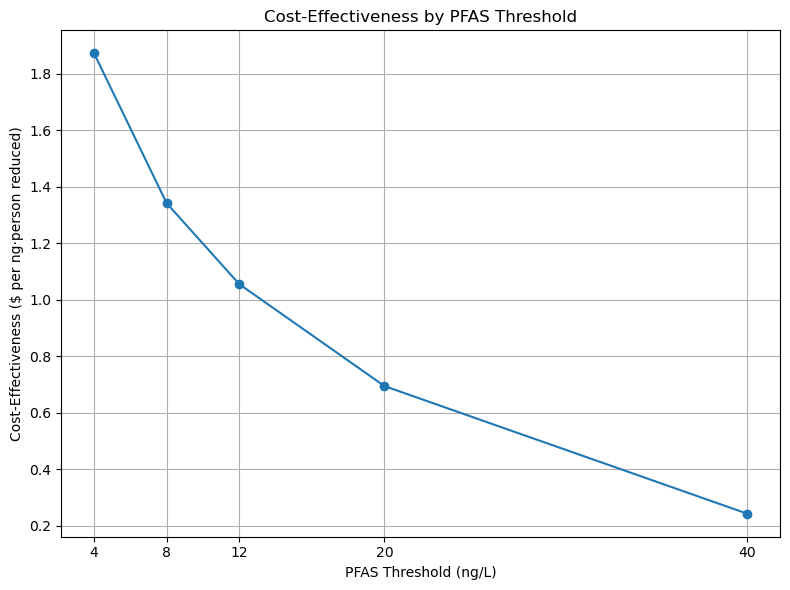

In [26]:
# Extract CE values in correct order
ce_values = [cost_effectiveness[t] for t in thresholds_ng]

plt.figure(figsize=(8,6))
plt.plot(thresholds_ng, ce_values, marker='o')

# FORCE the x-axis to show exactly these tick labels
plt.xticks(thresholds_ng)

plt.xlabel("PFAS Threshold (ng/L)")
plt.ylabel("Cost-Effectiveness ($ per ng·person reduced)")
plt.title("Cost-Effectiveness by PFAS Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
cols = [f"exceeds_{t}" for t in thresholds_ng]
exceed_by_bin = df.groupby("population_bin")[cols].mean() * 100
exceed_by_bin

,exceeds_4,exceeds_8,exceeds_12,exceeds_20,exceeds_40
population_bin,,,,,
"1,001 - 3,300",10.629067,6.724512,3.904555,1.952278,0.433839
"10,001 - 50,000",19.741860,13.083016,9.416251,4.136110,1.085362
"100,001 - 1,000,000",33.920705,23.127753,17.621145,11.674009,2.863436
101 - 500,10.091743,8.256881,5.504587,3.669725,1.834862
25 to 100,12.000000,6.666667,5.333333,1.333333,1.333333
"3,301 - 10,000",11.463964,7.252252,5.022523,2.409910,0.495495
"50,001 - 100,000",27.351916,18.466899,13.240418,6.445993,1.567944
"501 - 1,000",5.829596,3.139013,1.793722,0.896861,0.448430
"> 1,000,000",34.615385,23.076923,19.230769,7.692308,3.846154


<Figure size 1200x700 with 0 Axes>

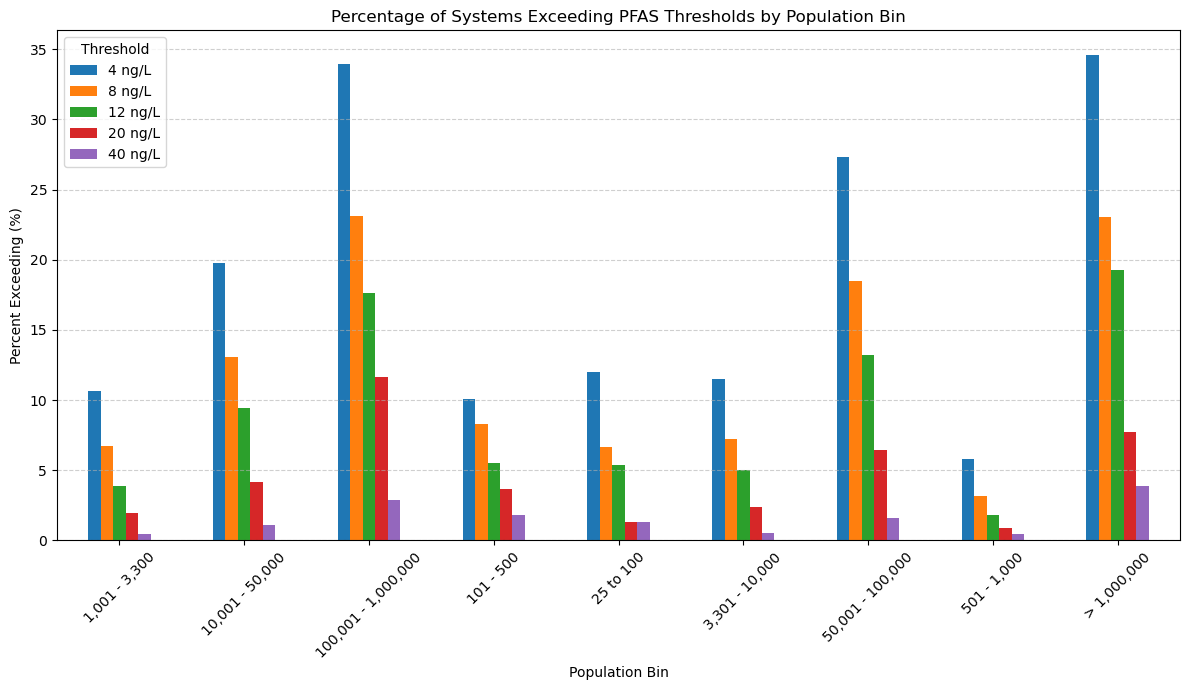

In [22]:
plt.figure(figsize=(12, 7))
exceed_by_bin.plot(kind='bar', figsize=(12,7))

plt.title("Percentage of Systems Exceeding PFAS Thresholds by Population Bin")
plt.xlabel("Population Bin")
plt.ylabel("Percent Exceeding (%)")
plt.legend([f"{t} ng/L" for t in thresholds_ng], title="Threshold")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()